# CVRP Notebook
This notebook is intended to run the top level code for the CVRP

In [1]:
import networkx as nx

from src.model import VRP, create_constraints, output_variables, create_example_2
from src.pricer import VRPPricer
from src.parse import parse

from matplotlib import pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [2]:
# G = parse("Instances/E/E-n22-k4.vrp")
# G = parse("Instances/E/E-n23-k3.vrp")
# G = parse("Instances/E/E-n30-k3.vrp")
# G = parse("Instances/E/E-n33-k4.vrp")
# G = parse("Instances/E/E-n51-k5.vrp")
# G = parse("Instances/E/E-n76-k14.vrp")
# G = parse("Instances/E/E-n101-k14.vrp")
# G = parse("Instances/Uchoa/X-n101-k25.vrp")
# G.graph['min_trucks'] = 26
# G = parse("Instances/Uchoa/X-n106-k14.vrp")
# G.graph['min_trucks'] = 14
# G = parse("Instances/Uchoa/X-n110-k13.vrp")
# G.graph['min_trucks'] = 13
# G = parse("Instances/Uchoa/X-n115-k10.vrp")
# G.graph['min_trucks'] = 10
G = parse("X-n120-k6",6)
# G = parse("Instances/Uchoa/X-n125-k30.vrp")
# G.graph['min_trucks'] = 30
# G = parse("Instances/Uchoa/X-n129-k18.vrp")
# G.graph['min_trucks'] = 18
# G = parse("Instances/Uchoa/X-n200-k36.vrp")
# G.graph['min_trucks'] = 36
# G = parse("Instances/Uchoa/X-n228-k23.vrp")
# G.graph['min_trucks'] = 23
# G = parse("Instances/Uchoa/X-n251-k28.vrp")
# G.graph['min_trucks'] = 28
# G = parse("Instances/Uchoa/X-n256-k16.vrp")
# G.graph['min_trucks'] = 16
# G = parse("Instances/Uchoa/X-n289-k60.vrp")
# G.graph['min_trucks'] = 61
# G = parse("Instances/Uchoa/X-n502-k39.vrp")
# G.graph['min_trucks'] = 39 #TODO: Ist dieses K auch das K, einer Optimallösung?

MAIN: Instance X-n120-k6
PARSE: There is no minimum number of trucks.
PARSE: Using the provided K = 6


In [3]:
model = VRP(G)

# Create pricer
pricer = VRPPricer(G)
pricer.data['methods'] = ["ng8","cyc2","SPPRC"]
pricer.data['max_vars']= 10000
pricer.data['time_limit'] = 120
pricer.data['farley'] = False

model.includePricer(pricer, "pricer","does pricing")

create_constraints(model,pricer,heuristic_stale_it=20, heuristic_max_it=2e4, heuristic_time=1e-2)

model.optimize()
model.hideOutput(quiet=False)

HYGESE: Found 52823 initial routes in 20000 rounds. Best sol val is 13370.0
Writing heuristic results
SETUP: methods are ['ng8', 'cyc2', 'SPPRC']
SETUP: time_limit is 120
PRICER_PY: The maximal path length is 23
PY PRICING: The neighborhood has been fixed to 8 neighbors.
PRICER_C: Graph data successfully copied to C.
presolving:
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 52942 variables (0 bin, 0 int, 0 impl, 52942 cont) and 120 constraints
    120 constraints of type <linear>
Presolving Time: 0.16

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
*22.1s|     1 |     0 |  6151 |     - |    LP  |   0 |  52k| 120 | 120 |   0 |  0 |   0 |   0 |      --      | 1.302354e+04 |    Inf | unknown
 28.2s|     

 1093s|     1 |     0 | 17026 |     - |   642M |   0 | 103k| 120 | 120 |   0 |  0 |   0 |   0 |      --      | 1.293962e+04 |    Inf | unknown
 1155s|     1 |     0 | 17037 |     - |   642M |   0 | 103k| 120 | 120 |   0 |  0 |   0 |   0 | 1.293962e+04 | 1.293962e+04 |   0.00%| unknown
 1155s|     1 |     0 | 17037 |     - |   642M |   0 | 103k| 120 | 120 |   0 |  0 |   0 |   0 | 1.293962e+04 | 1.293962e+04 |   0.00%| unknown

SCIP Status        : problem is solved [optimal solution found]
Solving Time (sec) : 1154.73
Solving Nodes      : 1
Primal Bound       : +1.29396221726842e+04 (48 solutions)
Dual Bound         : +1.29396221726842e+04
Gap                : 0.00 %


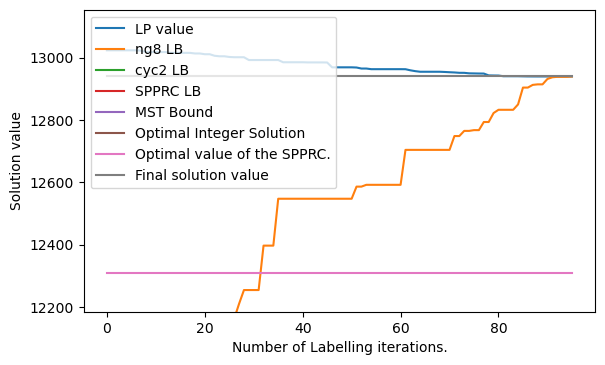

In [14]:
# This value is the exact pagewidth of latex
plt.figure(figsize=(6.6,4),dpi=100)

upper_bounds = [x for x,y in pricer.data['bounds'][pricer.data['methods'][0]]]
plt.plot(upper_bounds, label="LP value")

xmax = 0
for method in pricer.data['methods']:
    lower_bounds = []
    best_lb = pricer.data['bounds'][method][0][1]
    for x,y in pricer.data['bounds'][method]:
        if y > best_lb:
            best_lb = y
        lower_bounds.append(best_lb)
    plt.plot(lower_bounds, label=f'{method} LB')
    xmax = max(upper_bounds[0],xmax)

T = nx.minimum_spanning_tree(G)
mst = T.size(weight='weight') + min(G.edges().data('weight'),key=lambda edge: edge[2])[2]
mst = [mst for i in range(len(upper_bounds))]
plt.plot(mst, label="MST Bound")

optimal = [13332 for i in range(len(upper_bounds))]
plt.plot(optimal, label="Optimal Integer Solution")

spprc = [12308 for i in range(len(upper_bounds))]
plt.plot(spprc, label="Optimal value of the SPPRC.")

# ng8 = [481 for i in range(len(upper_bounds))]
# plt.plot(ng8, label="Optimal value of ng 8.")

# cyc2 = [464.2 for i in range(len(upper_bounds))]
# plt.plot(cyc2, label="Optimal value of 2-cycle Elimination.")

if pricer.data['farley']:
    farley_bounds = pricer.data['farley_bound']
    plt.plot(farley_bounds, label="Farley Bound")

solval = model.getObjVal()
sol = [solval for i in range(len(upper_bounds))]
plt.plot(sol,label="Final solution value")

plt.ylim((spprc[0]*0.99,xmax*1.01))

plt.legend(loc='upper left')
plt.xlabel("Number of Labelling iterations.")
plt.ylabel("Solution value")
# plt.savefig("plots/E-n30-k3.espprc.pgf")
plt.show()

In [5]:
output_variables(model, pricer)

The solution contains the following paths: 
Only paths with associated value larger than 1e-06 are analysed.
The following path is non elementary
0.16275905061071425 * x95761: (0, 50, 88, 10, 119, 94, 84, 16, 80, 29, 25, 73, 31, 38, 52, 88, 10, 94, 119, 61, 116, 20, 0)
0.011857637688841016 * x95767: (0, 50, 52, 38, 29, 32, 91, 21, 12, 2, 49, 42, 39, 78, 8, 3, 45, 112, 71, 96, 107, 20, 0)
0.117410761144777 * x95814: (0, 45, 3, 114, 90, 53, 81, 69, 68, 60, 95, 4, 22, 59, 100, 77, 57, 35, 92, 6, 40, 54, 0)
0.010229795012402365 * x95818: (0, 45, 3, 114, 90, 53, 81, 69, 68, 60, 95, 4, 22, 59, 100, 77, 57, 35, 92, 6, 40, 62, 0)
The following path is non elementary
0.01954793668348652 * x97412: (0, 54, 62, 40, 6, 92, 35, 1, 24, 37, 100, 77, 57, 37, 24, 1, 56, 11, 27, 34, 111, 102, 0)
The following path is non elementary
0.0978628244612904 * x99828: (0, 20, 54, 62, 87, 72, 102, 111, 34, 27, 11, 56, 35, 92, 6, 111, 102, 72, 87, 62, 54, 20, 0)
0.054906568973060225 * x99829: (0, 61, 119, 84, 93, 